In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [130]:
data = pd.read_csv('data/Annual changes in global temperature 18801985.csv')
data.set_index('x').sort_index()

,Unnamed: 0
x,
-0.72,5
-0.54,6
-0.54,8
-0.49,14
-0.49,25
...,...
0.19,59
0.20,74
0.27,101


Скользящее среднее

In [75]:
data['MA_window_3'] = data['x'].rolling(window=2).mean()
data

,Unnamed: 0,x,MA_window_3
0,1,-0.40,NaN
1,2,-0.37,-0.385
2,3,-0.43,-0.400
3,4,-0.47,-0.450
4,5,-0.72,-0.595
...,...,...,...
101,102,0.42,0.345
102,103,0.02,0.220
103,104,0.30,0.160
104,105,0.09,0.195


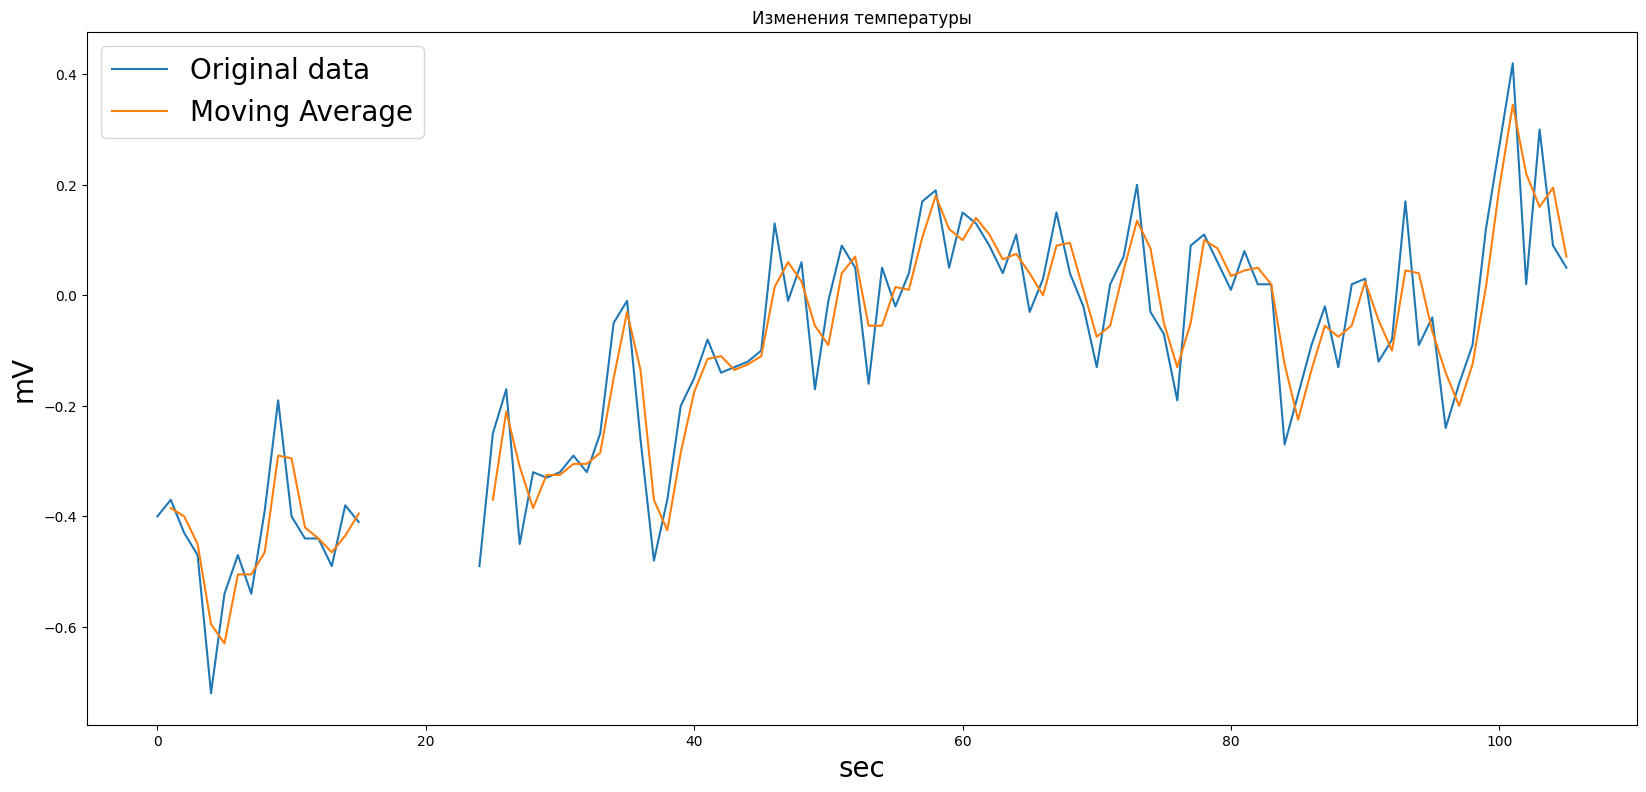

In [76]:
fig = plt.figure(figsize=(20, 9))
plt.plot(data['x'], label='Original data')
plt.plot(data['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Изменения температуры')
plt.ylabel('mV', fontsize="20")
plt.xlabel('sec', fontsize="20")
plt.show()

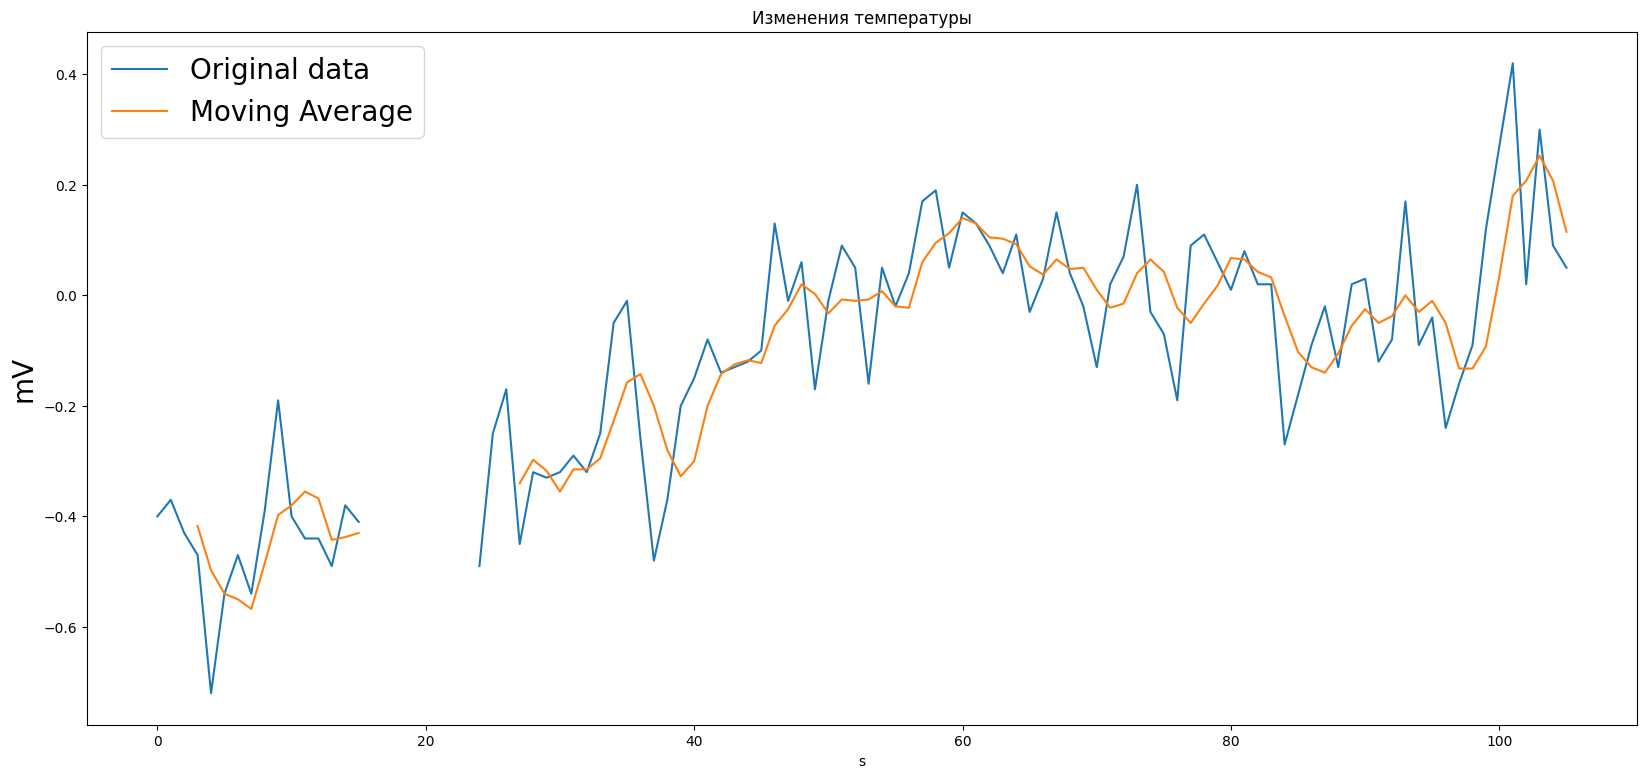

In [77]:
data['MA_window_6'] = data['x'].rolling(window=4).mean()
fig = plt.figure(figsize=(20, 9))
plt.plot(data['x'], label='Original data')
plt.plot(data['MA_window_6'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Изменения температуры')
plt.ylabel('mV', fontsize="20")
plt.xlabel('s')
plt.show()

In [78]:
'''
Отрисовка скользящего среднего по медиане для ts с 95% доверительным интервалом для стандартного отклонения.
:parameter
  :param ts: датасет
  :param window: кол-во семплов в окне - для скользящих средних
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=100,
            figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='Реальные значения', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
                 color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                     color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

/tmp/ipykernel_8094/3736708662.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


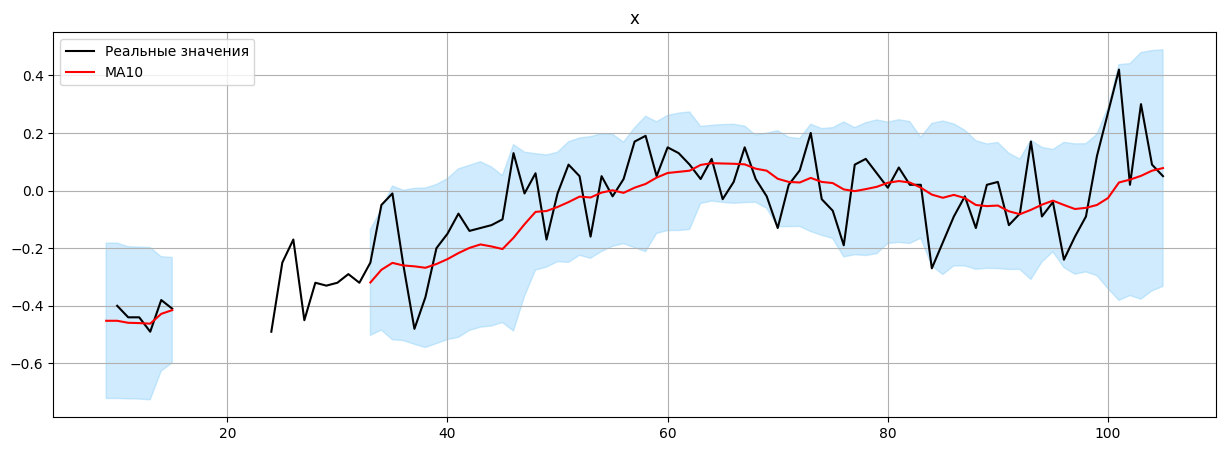

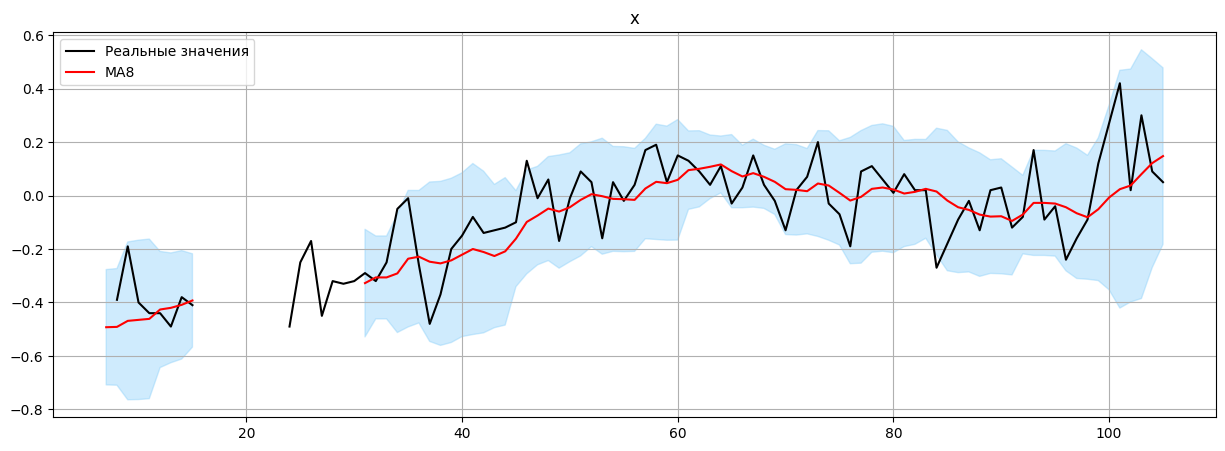

In [79]:
plot_ts(data["x"], window=10)
plot_ts(data["x"], window=8)

ARMA

In [80]:
from statsmodels.tsa.arima.model import ARIMA

Предсказание ряда на основе предыдущих значений

ARIMA

In [81]:
arma_model = ARIMA(data['x'], order=(5,0,3))
arma_model_fit = arma_model.fit()

/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  106
Model:                 ARIMA(5, 0, 3)   Log Likelihood                  68.215
Date:                Thu, 19 Oct 2023   AIC                           -116.430
Time:                        18:52:41   BIC                            -89.796
Sample:                             0   HQIC                          -105.635
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1950      0.386     -0.505      0.614      -0.952       0.562
ar.L1         -0.1037      0.425     -0.244      0.807      -0.937       0.729
ar.L2          0.9404      0.236      3.985      0.0

In [83]:
X = data['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [84]:
print(len(train))
print(len(test))
print(len(arma_predictions))

69
37
37


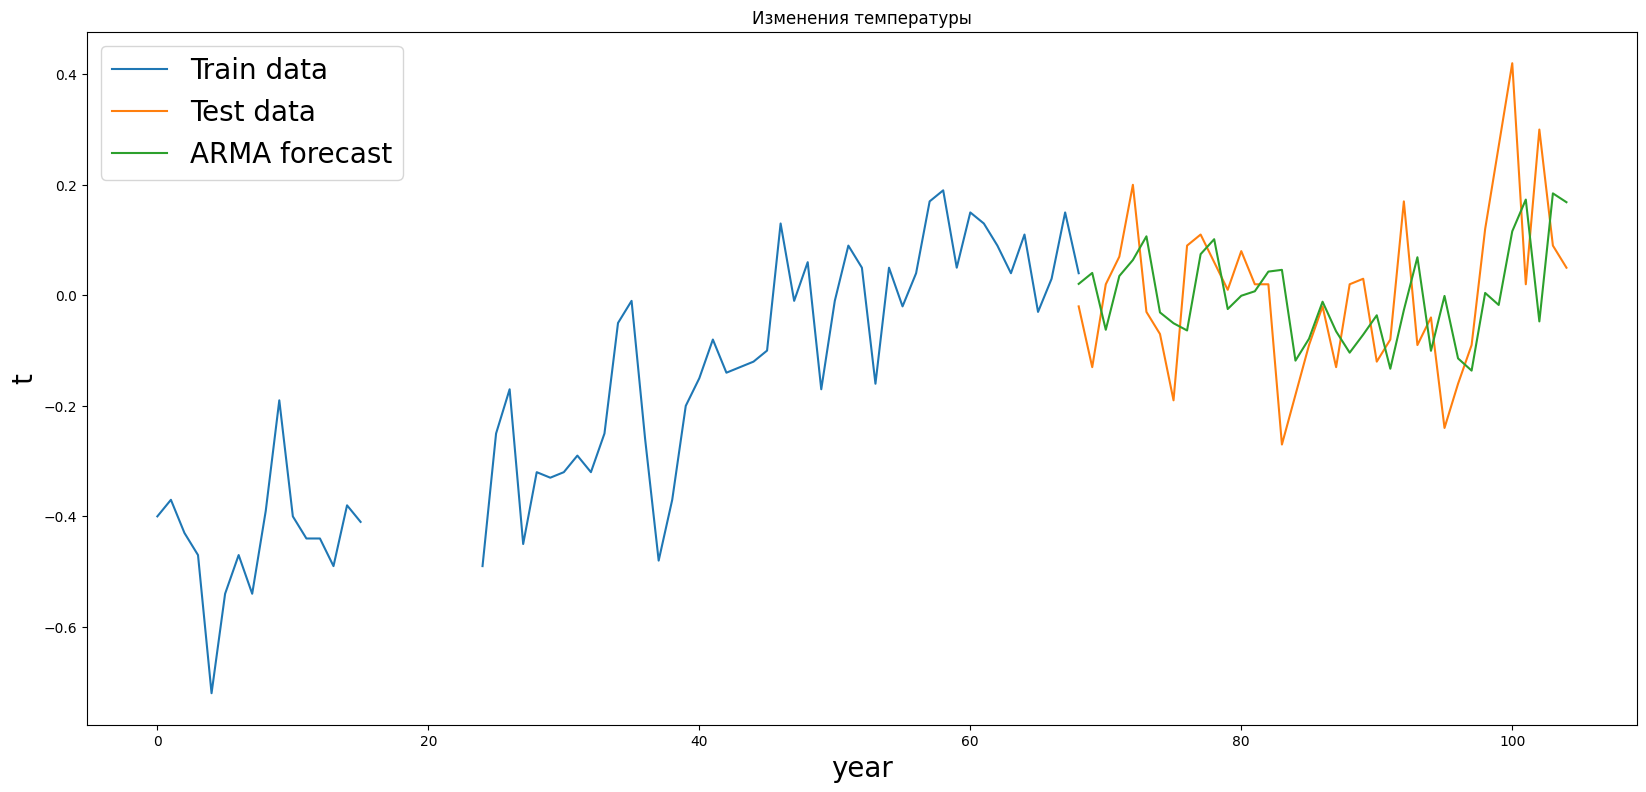

In [85]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('Изменения температуры')
plt.ylabel('t', fontsize="20")
plt.xlabel('year', fontsize="20")
plt.show()

In [86]:
from IPython.display import clear_output
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show()

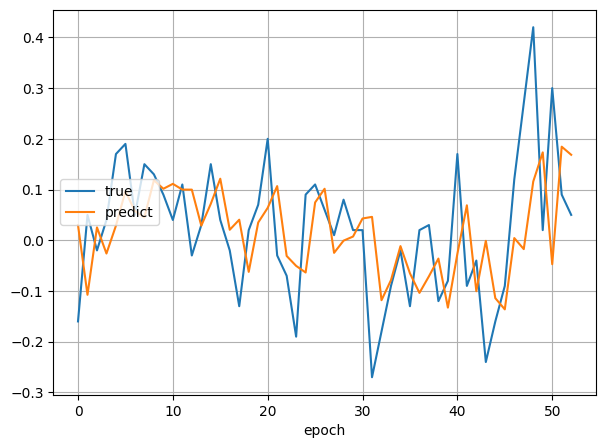

In [87]:
series = data['x']

size = int(series.shape[0] * 0.5)
train, test = series[:size], series[size:len(series)]
history = [x for x in train.values]
predictions = []

val = {"true":[], "predict":[]}
for t in test.values:
    model = ARIMA(history, order=(5,1,0)).fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    val["predict"].append(yhat)
    val["true"].append(t)
    history.append(t)
    live_plot(val)

In [88]:
arima_model = ARIMA(data['x'], order=(10,2,10))
arima_model_fit = arima_model.fit()

/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [89]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  106
Model:               ARIMA(10, 2, 10)   Log Likelihood                  72.631
Date:                Thu, 19 Oct 2023   AIC                           -103.261
Time:                        18:53:29   BIC                            -47.729
Sample:                             0   HQIC                           -80.764
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2671      0.678     -1.870      0.061      -2.595       0.061
ar.L2         -1.1062      1.087     -1.018      0.309      -3.236       1.023
ar.L3         -0.9332      1.268     -0.736      0.4

Линейный график остаточных ошибок

<Axes: >

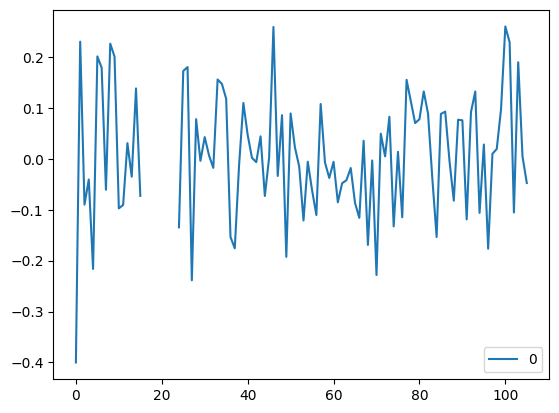

In [90]:
arima_residuals = pd.DataFrame(arima_model_fit.resid)
arima_residuals.plot()

In [91]:
output = arima_model_fit.forecast()

In [92]:
X = data['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
    arima_model = ARIMA(history, order=(10,2,5))
    arima_model_fit = arima_model.fit()
    output = arima_model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/user-prog/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/user-prog/.local/lib/py

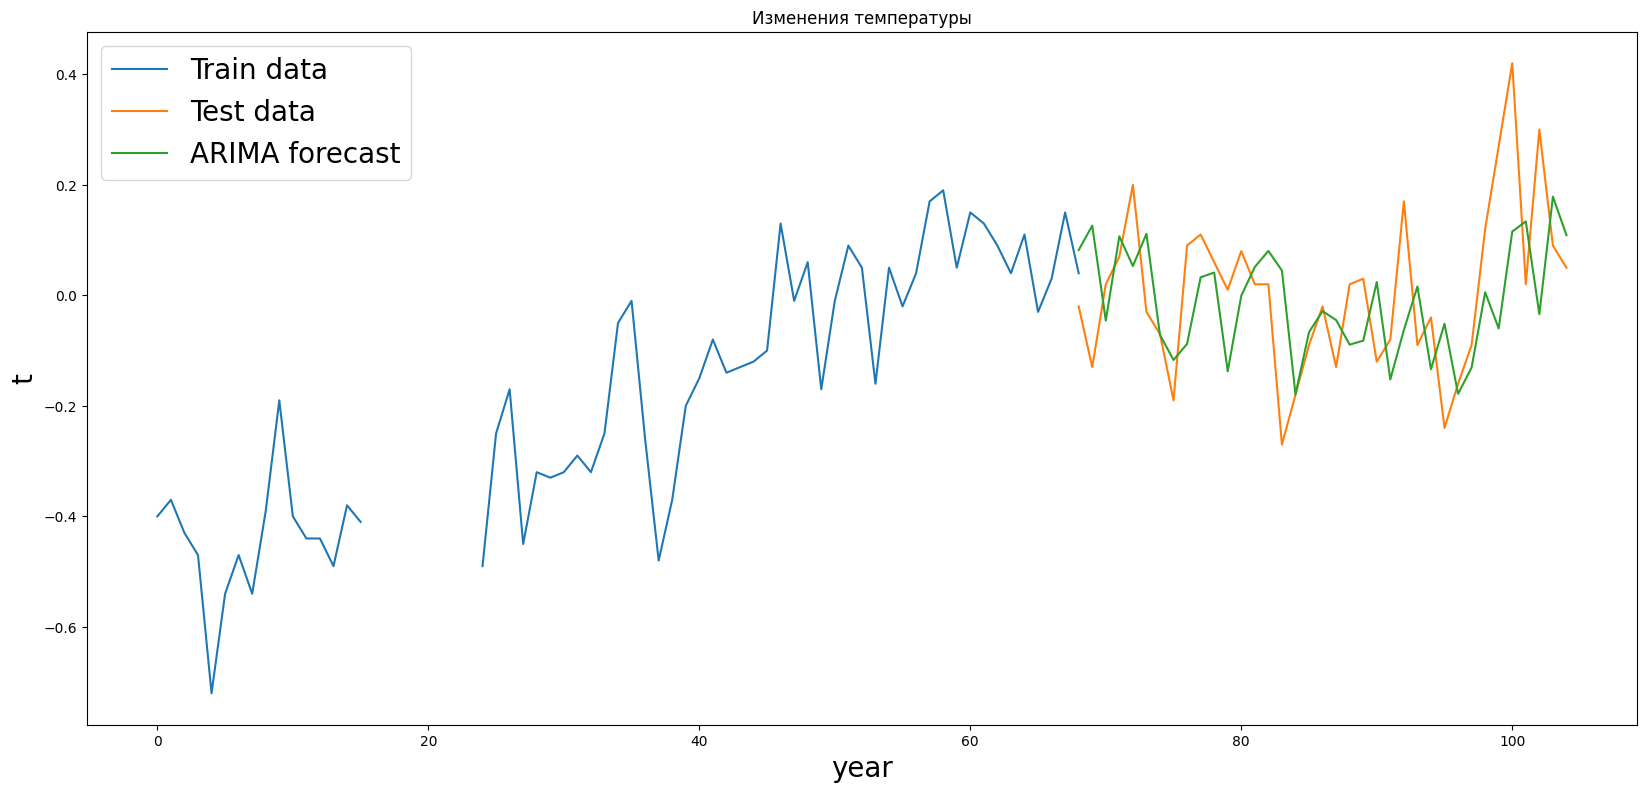

In [93]:
fig = plt.figure(figsize=(20, 9))
plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, len(X) - 1)], test, label='Test data')
plt.plot([i for i in range(size - 1, len(X) - 1)], arima_predictions, label='ARIMA forecast')
plt.legend(fontsize="20")
plt.title('Изменения температуры')
plt.ylabel('t', fontsize="20")
plt.xlabel('year', fontsize="20")
plt.show()

Сравнение значения ARMA и ARIMA

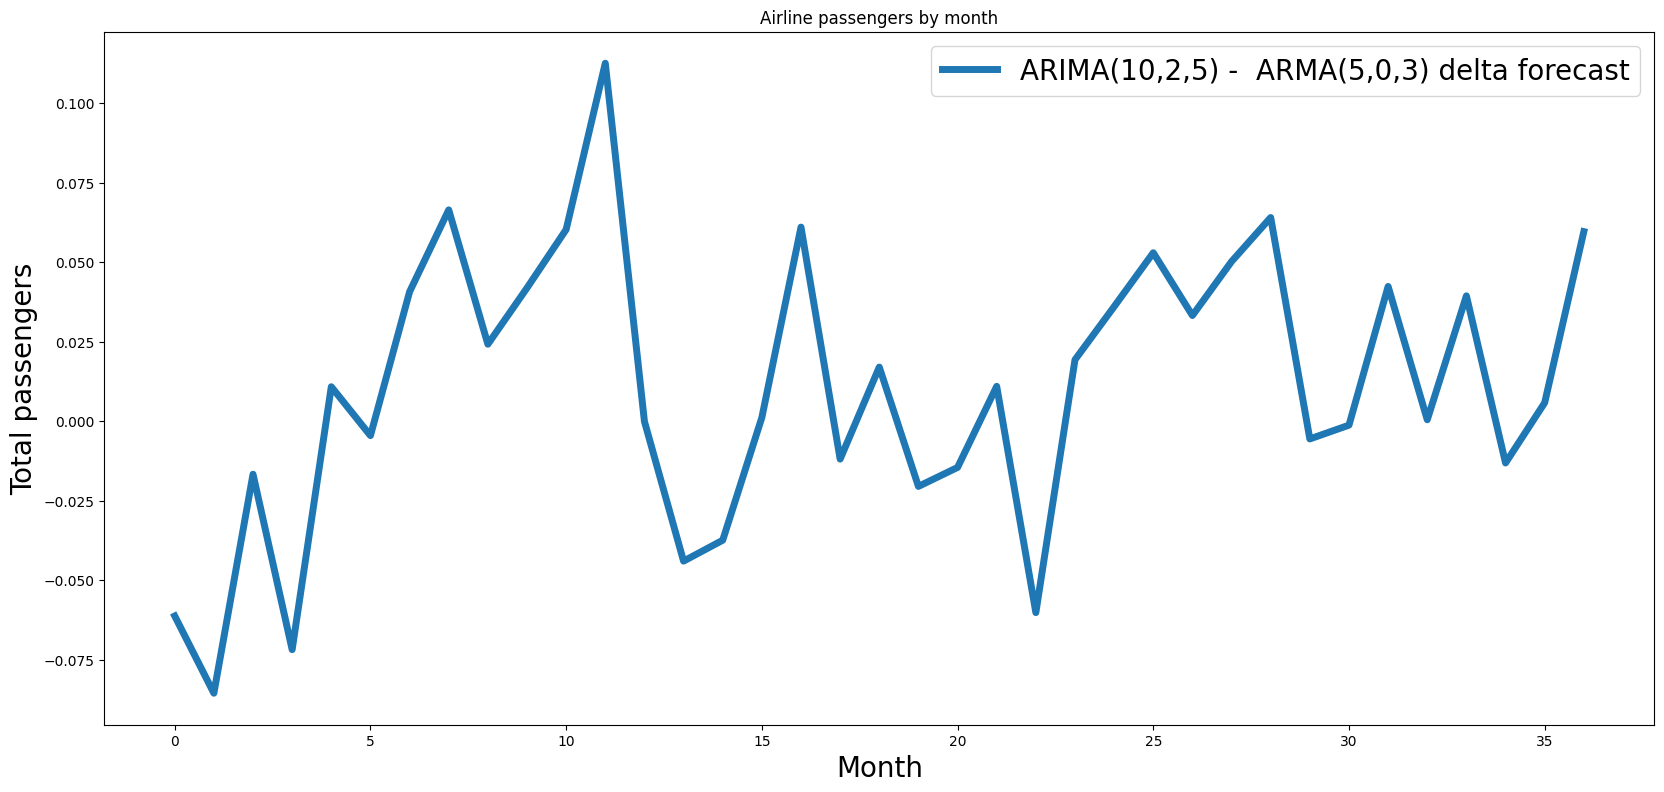

In [94]:
fig = plt.figure(figsize=(20, 9))

delta = []

for i in range(len(arima_predictions)):
    delta.append(arma_predictions[i] - arima_predictions[i])

plt.plot(delta, label='ARIMA(10,2,5) -  ARMA(5,0,3) delta forecast', linewidth=5)
plt.legend(fontsize="20")
plt.title('Airline passengers by month')
plt.ylabel('Total passengers', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

Работа с пропусками в данных

Заполнение средним

<Axes: >

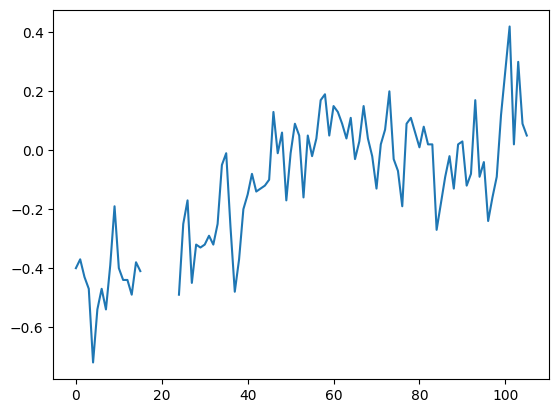

In [115]:
o_df = data["x"].copy()
o_df.plot()

-0.44999999999999996


<Axes: title={'center': 'среднее из предыдущего и последующего'}>

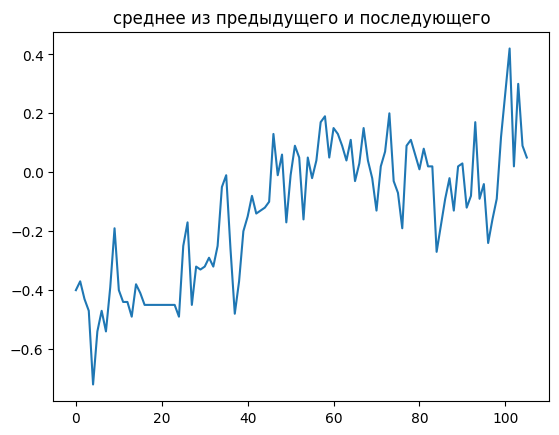

In [116]:
new_value = (o_df[24] + o_df[15])/2
print(new_value)

o_df[16:24] = new_value

o_df.plot(title="среднее из предыдущего и последующего")

-0.49


<Axes: title={'center': 'Последующее значение'}>

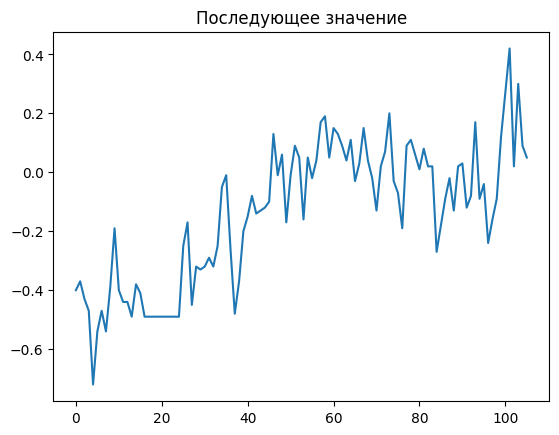

In [117]:
new_value = o_df[24]
print(new_value)

o_df[16:24] = new_value

o_df.plot(title='Последующее значение')

-0.41


<Axes: title={'center': 'Предыдущее значение'}>

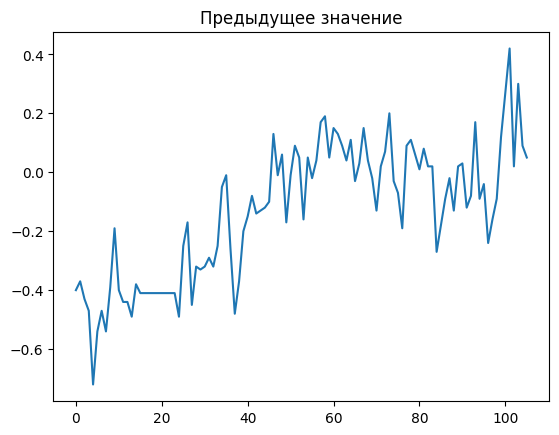

In [118]:
new_value = o_df[15]
print(new_value)

o_df[16:24] = new_value

o_df.plot(title='Предыдущее значение')

-0.095


<Axes: title={'center': 'медиана'}>

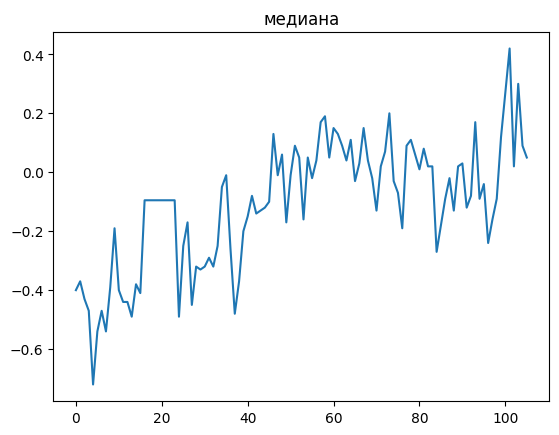

In [119]:
new_value = o_df.median()
print(new_value)

o_df[16:24] = new_value

o_df.plot(title='медиана')

-0.11066037735849057


<Axes: title={'center': 'среднее'}>

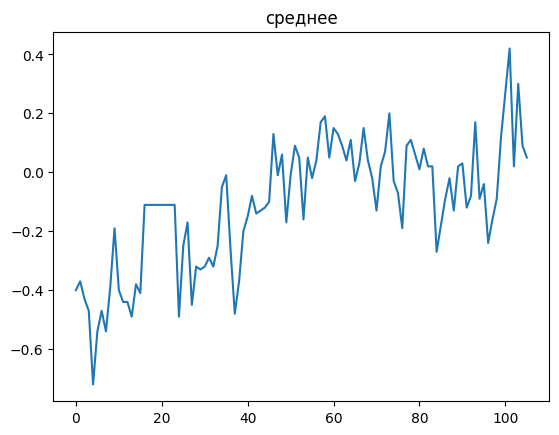

In [120]:
new_value = o_df.mean()
print(new_value)

o_df[16:24] = new_value

o_df.plot(title='среднее') 

Интерполяция

<Axes: title={'center': 'zero'}>

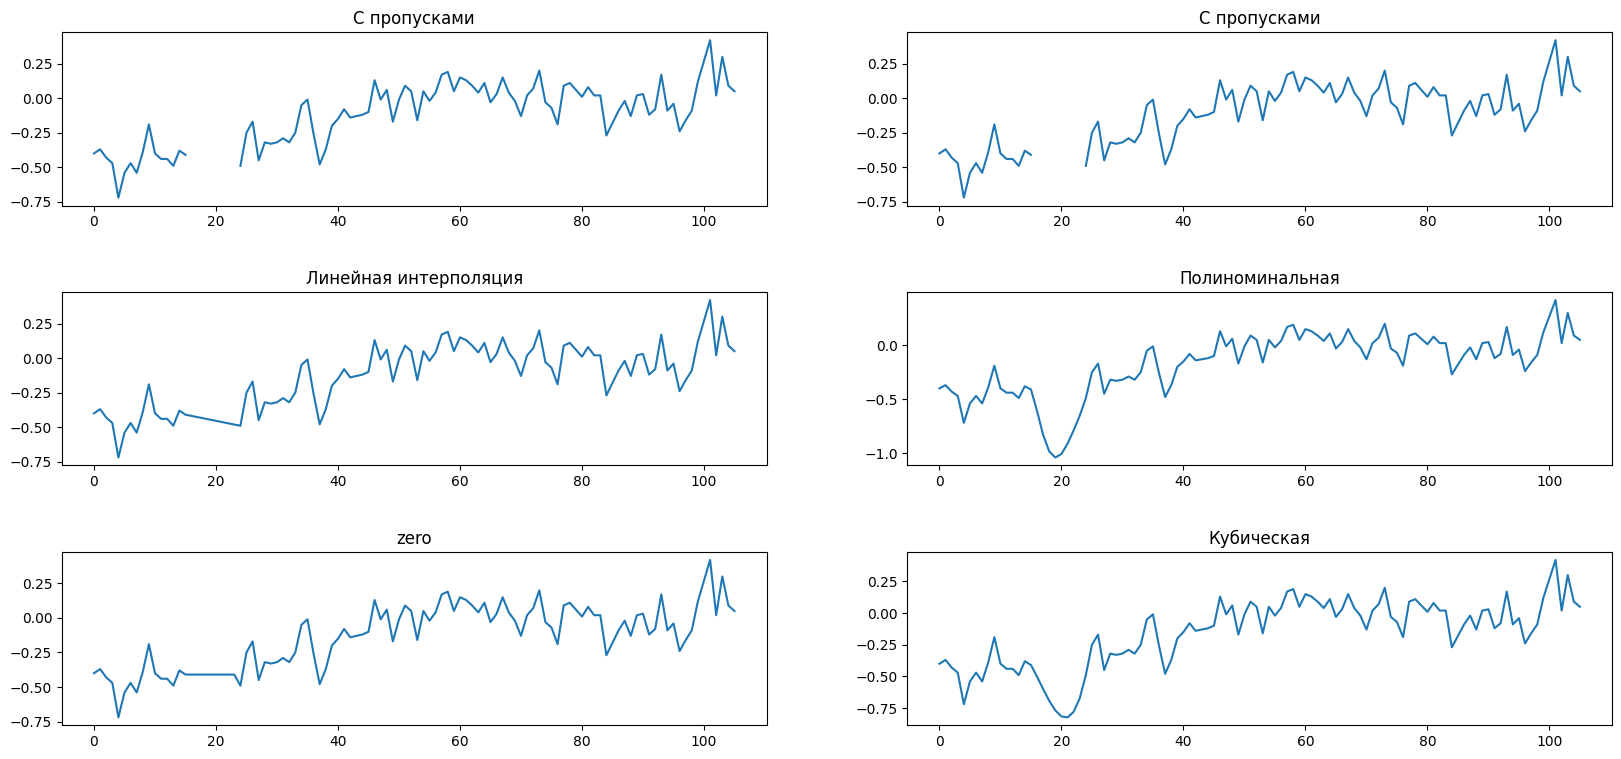

In [121]:
o_df[16:24] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=5)

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))
 
o_df.plot(title="С пропусками", ax = original_ax)  
o_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))  
lin_df.plot(title="Линейная интерполяция", ax = lin_ax) 
cub_df.plot(title="Кубическая", ax = cub_ax) 
pol_df.plot(title="Полиноминальная", ax = pol_ax) 
zero_df.plot(title="zero", ax=zero_ax)

Работа с выбросами

In [122]:
import seaborn as sns

<Axes: >

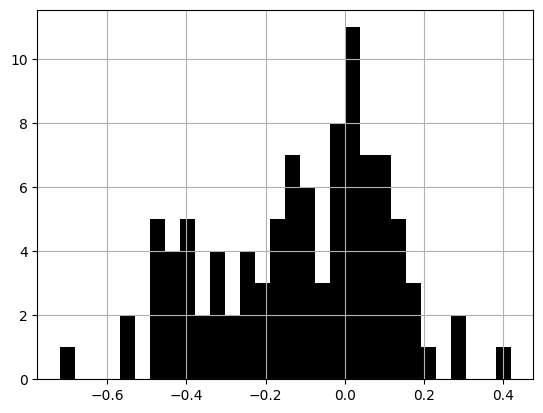

In [123]:
data["x"].hist(bins=30, color="black")

Text(0.5, 1.0, 'Изменения температуры')

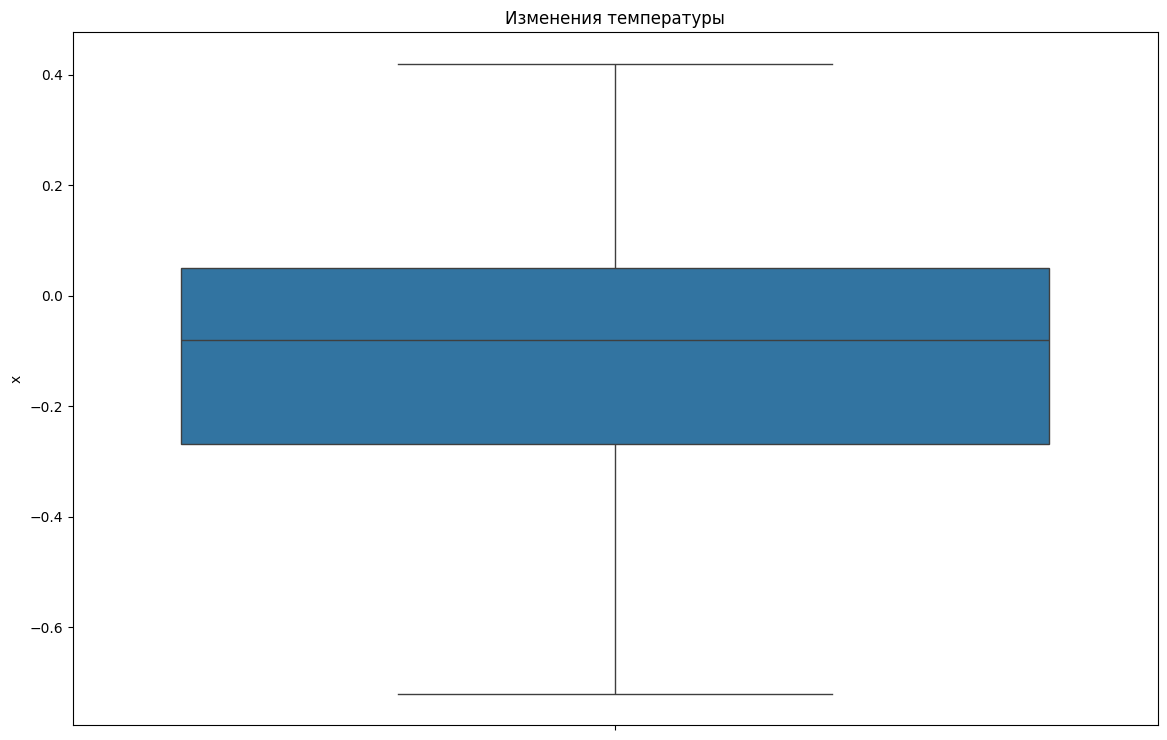

In [125]:
fig = plt.figure(figsize=(14, 9))
 
sns.boxplot(data.x).set_title('Изменения температуры')

In [126]:
from sklearn import preprocessing, svm

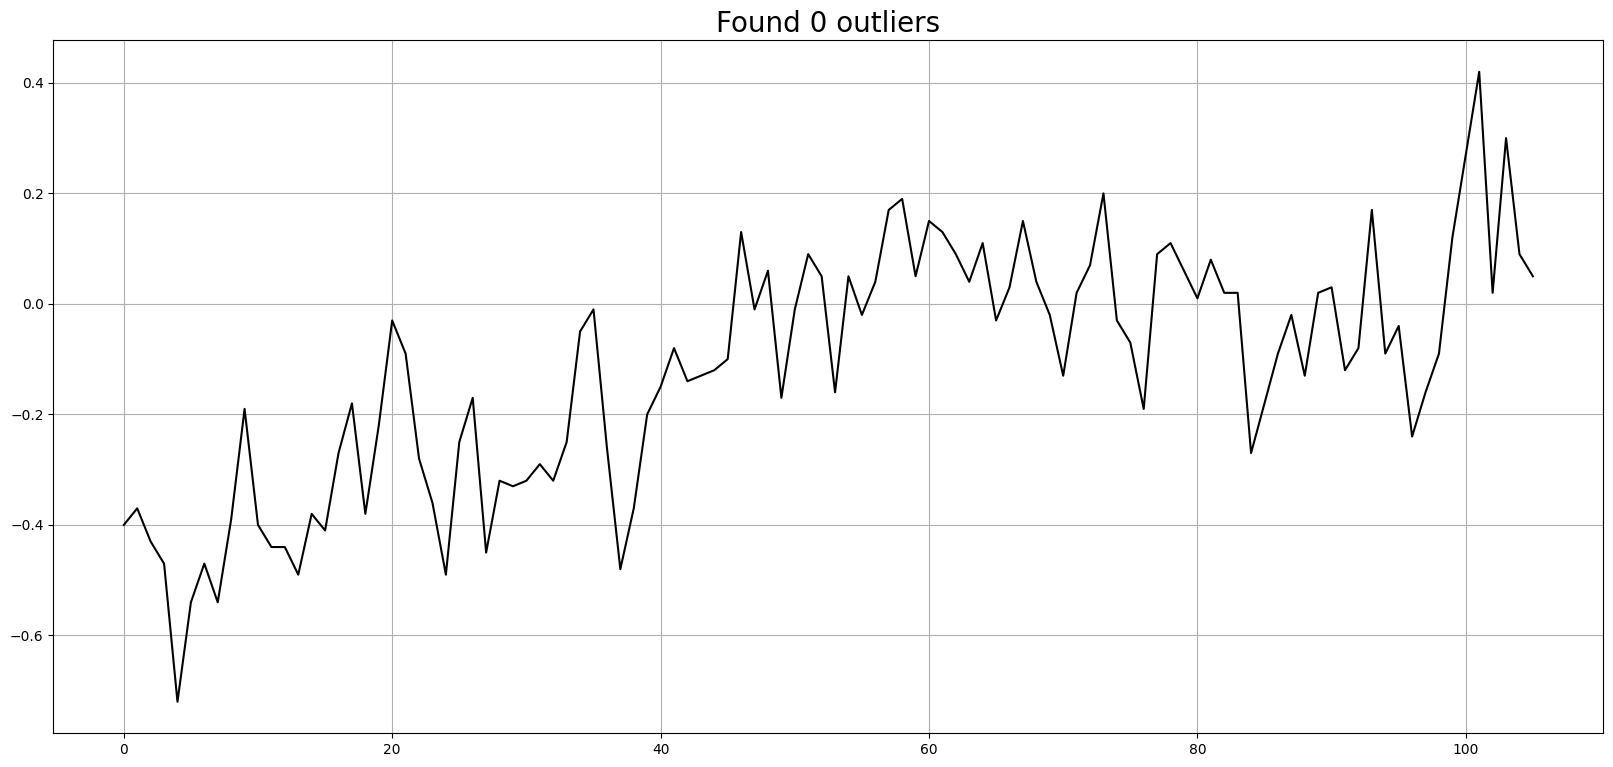

In [131]:
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = data["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)
## dtf output
dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                                            x: 1 if x==-1 else 0)
## plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()